# Refactoring Strategy
`Python 3.10.8`

We want to refactor the code using functions, significantly reducing the line count.

Consider an online store with these discount rules:
- Customers with 1,000 or more fidelity points get a global 5% discount per order.
- A 10% discount is applied to each line item with 20 or more units in the same order.
- Orders with at least 10 distinct items get a 7% global discount.

For brevity, let’s assume that only one discount may be applied to an order.

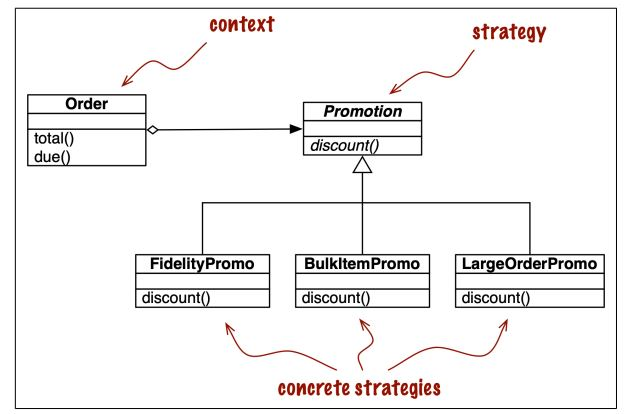

Content
- Provides a service by delegating some computation to interchangeable compo‐ nents that implement alternative algorithms.
- `Order`, which is configured to apply a promotional discount according to one of several algorithms.

Strategy
- The interface common to the components that implement the different algorithms.
- `Promotion`, an abstract class.

Concrete strategy
- One of the concrete subclasses of Strategy.
- `FidelityPromo`, `BulkPromo`, and `LargeOrderPromo` are the three concrete strategies implemented.

### Classic Strategy

In [1]:
from abc import ABC, abstractmethod
from collections import namedtuple
from decimal import Decimal
from typing import NamedTuple, Optional, Sequence, Callable

In [2]:
class Customer(NamedTuple):
    name: str
    fidelity: int

class LineItem(NamedTuple):
    product: str
    quantity: int
    price: Decimal

    def total(self) -> Decimal:
        return self.price * self.quantity

In [3]:
class Order(NamedTuple):  # the Context
    customer: Customer
    cart: Sequence[LineItem]
    promotion: Optional['Promotion'] = None

    def total(self) -> Decimal:
        totals = (item.total() for item in self.cart)
        return sum(totals, Decimal(0))

    def due(self) -> Decimal:
        if self.promotion is None:
            discount = Decimal(0)
        else:
            discount = self.promotion.discount(self)
        return self.total() - discount

    def __repr__(self):
        return f'<Order total: {self.total():.2f} due: {self.due():.2f}>'

In [4]:
class Promotion(ABC):  # the Strategy: an abstract base class
    @abstractmethod
    def discount(self, order: Order) -> Decimal:
        """Return discount as a positive dollar amount"""

In [5]:
class FidelityPromo(Promotion):  # first Concrete Strategy
    """5% discount for customers with 1000 or more fidelity points"""

    def discount(self, order: Order) -> Decimal:
        rate = Decimal('0.05')
        if order.customer.fidelity >= 1000:
            return order.total() * rate
        return Decimal(0)


class BulkItemPromo(Promotion):  # second Concrete Strategy
    """10% discount for each LineItem with 20 or more units"""

    def discount(self, order: Order) -> Decimal:
        discount = Decimal(0)
        for item in order.cart:
            if item.quantity >= 20:
                discount += item.total() * Decimal('0.1')
        return discount


class LargeOrderPromo(Promotion):  # third Concrete Strategy
    """7% discount for orders with 10 or more distinct items"""

    def discount(self, order: Order) -> Decimal:
        distinct_items = {item.product for item in order.cart}
        if len(distinct_items) >= 10:
            return order.total() * Decimal('0.07')
        return Decimal(0)

In [6]:
joe = Customer('John Doe', 0)
ann = Customer('Ann Smith', 1100)
cart = (LineItem('banana', 4, Decimal('.5')),
        LineItem('apple', 10, Decimal('1.5')),
        LineItem('watermelon', 5, Decimal(5)))
banana_cart = (LineItem('banana', 30, Decimal('.5')),
               LineItem('apple', 10, Decimal('1.5')))
long_cart = tuple(LineItem(str(sku), 1, Decimal(1)) for sku in range(10))

In [7]:
print("Order(joe, cart, FidelityPromo()):", Order(joe, cart, FidelityPromo()))
print("Order(ann, cart, FidelityPromo()):", Order(ann, cart, FidelityPromo()))

print("Order(joe, banana_cart, BulkItemPromo()):", Order(joe, banana_cart, BulkItemPromo()))
print("Order(joe, long_order, LargeOrderPromo()):", Order(joe, long_cart, LargeOrderPromo()))
print("Order(joe, cart, LargeOrderPromo()):", Order(joe, cart, LargeOrderPromo()))

Order(joe, cart, FidelityPromo()): <Order total: 42.00 due: 42.00>
Order(ann, cart, FidelityPromo()): <Order total: 42.00 due: 39.90>
Order(joe, banana_cart, BulkItemPromo()): <Order total: 30.00 due: 28.50>
Order(joe, long_order, LargeOrderPromo()): <Order total: 10.00 due: 9.30>
Order(joe, cart, LargeOrderPromo()): <Order total: 42.00 due: 42.00>


### Function-Oriented Strategy
There is no need to instantiate a new promotion object with each new order: the functions are ready to use.</b>

`<1>` This type hint says: promotion may be None, or it may be a callable that takes an `Order` argument and returns a `Decimal`.

`<2>` To compute a discount, call the `self.promotion` callable, passing `self` as an argument. See the following tip for the reason.

`<3>` No abstract class.

`<4>` Each strategy is a function.

In [8]:
class Order(NamedTuple):  # the Context
    customer: Customer
    cart: Sequence[LineItem]
    promotion: Optional[Callable[['Order'], Decimal]] = None  # <1>
  # promotion: Optional['Promotion'] = None

    def total(self) -> Decimal:
        totals = (item.total() for item in self.cart)
        return sum(totals, start=Decimal(0))

    def due(self) -> Decimal:
        if self.promotion is None:
            discount = Decimal(0)
        else:
            discount = self.promotion(self)  # <2>
          # discount = self.promotion.discount(self)
        return self.total() - discount

    def __repr__(self):
        return f'<Order total: {self.total():.2f} due: {self.due():.2f}>'

In [9]:
##### <3>
# class Promotion(ABC):  # the Strategy: an abstract base class
#     @abstractmethod
#     def discount(self, order: Order) -> Decimal:
#         """Return discount as a positive dollar amount"""
#
# class FidelityPromo(Promotion):
#     ...

def fidelity_promo(order: Order) -> Decimal:  # <4>
    """5% discount for customers with 1000 or more fidelity points"""
    if order.customer.fidelity >= 1000:
        return order.total() * Decimal('0.05')
    return Decimal(0)


def bulk_item_promo(order: Order) -> Decimal:
    """10% discount for each LineItem with 20 or more units"""
    discount = Decimal(0)
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * Decimal('0.1')
    return discount


def large_order_promo(order: Order) -> Decimal:
    """7% discount for orders with 10 or more distinct items"""
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * Decimal('0.07')
    return Decimal(0)

In [10]:
print("Order(joe, cart, fidelity_promo):", Order(joe, cart, fidelity_promo))
print("Order(ann, cart, fidelity_promo):", Order(ann, cart, fidelity_promo))

print("Order(joe, banana_cart, bulk_item_promo):", Order(joe, banana_cart, bulk_item_promo))
print("Order(joe, long_order, large_order_promo):", Order(joe, long_cart, large_order_promo))
print("Order(joe, cart, large_order_promo):", Order(joe, cart, large_order_promo))

Order(joe, cart, fidelity_promo): <Order total: 42.00 due: 42.00>
Order(ann, cart, fidelity_promo): <Order total: 42.00 due: 39.90>
Order(joe, banana_cart, bulk_item_promo): <Order total: 30.00 due: 28.50>
Order(joe, long_order, large_order_promo): <Order total: 10.00 due: 9.30>
Order(joe, cart, large_order_promo): <Order total: 42.00 due: 42.00>


### Choosing the Best Strategy: Simple Approach
A shared object that can be used in multiple contexts simultaneously to reduce runtime cost.

`<1>` `promos`: list of the strategies implemented as functions.

`<2>` `best_promo` takes an instance of `Order` as argument, as do the other `*_promo` functions.

`<3>` Using a generator expression, we apply each of the functions from `promos` to the `order`, and return the maximum discount computed.

In [11]:
promos = [fidelity_promo, bulk_item_promo, large_order_promo] # <1>

def best_promo(order: Order) -> Decimal: # <2>
    """Compute the best discount available"""
    return max(promo(order) for promo in promos) # <3>

In [12]:
print("Order(joe, long_cart, best_promo):", Order(joe, long_cart, best_promo))
print("Order(joe, banana_cart, best_promo):", Order(joe, banana_cart, best_promo))
print("Order(ann, cart, best_promo):", Order(ann, cart, best_promo))

Order(joe, long_cart, best_promo): <Order total: 10.00 due: 9.30>
Order(joe, banana_cart, best_promo): <Order total: 30.00 due: 28.50>
Order(ann, cart, best_promo): <Order total: 42.00 due: 39.90>


### Finding Strategies in a Module
`globals()`: Return a dictionary representing the current global symbol table. This is always
the dictionary of the current module (inside a function or method, this is the
module where it is defined, not the module from which it is called).

`<1>` Iterate over each item in the dict returned by `globals()`.

`<2>` Select only values where the name ends with the `_promo` suffix and filter out `best_promo` itself, to avoid an infinite recursion when `best_promo` is called.

In [14]:
print("globals().items():\n")
for k, v in globals().items():
    print(k, v)

globals().items():

__name__ __main__
__doc__ Automatically created module for IPython interactive environment
__package__ None
__loader__ None
__spec__ None
__builtin__ <module 'builtins' (built-in)>
__builtins__ <module 'builtins' (built-in)>
_ih ['', 'from abc import ABC, abstractmethod\nfrom collections import namedtuple\nfrom decimal import Decimal\nfrom typing import NamedTuple, Optional, Sequence, Callable', 'class Customer(NamedTuple):\n    name: str\n    fidelity: int\n\nclass LineItem(NamedTuple):\n    product: str\n    quantity: int\n    price: Decimal\n\n    def total(self) -> Decimal:\n        return self.price * self.quantity', "class Order(NamedTuple):  # the Context\n    customer: Customer\n    cart: Sequence[LineItem]\n    promotion: Optional['Promotion'] = None\n\n    def total(self) -> Decimal:\n        totals = (item.total() for item in self.cart)\n        return sum(totals, Decimal(0))\n\n    def due(self) -> Decimal:\n        if self.promotion is None:\n          

In [15]:
promos = [promo for name, promo in globals().items() # <1>
          if name.endswith('_promo') and name != 'best_promo'] # <2>

print("promos:", promos)

promos: [<function fidelity_promo at 0x7f8648611000>, <function bulk_item_promo at 0x7f8648611090>, <function large_order_promo at 0x7f8648611750>]


In [16]:
print("Order(joe, long_cart, best_promo):", Order(joe, long_cart, best_promo))
print("Order(joe, banana_cart, best_promo):", Order(joe, banana_cart, best_promo))
print("Order(ann, cart, best_promo):", Order(ann, cart, best_promo))

Order(joe, long_cart, best_promo): <Order total: 10.00 due: 9.30>
Order(joe, banana_cart, best_promo): <Order total: 30.00 due: 28.50>
Order(ann, cart, best_promo): <Order total: 42.00 due: 39.90>


In [17]:
import sys, inspect

# Inspect a list of all classes within current module in Python
promos = [func for _, func in inspect.getmembers(sys.modules[__name__], inspect.isfunction)]

print("promos:", promos)
print()

promos = [func for name, func in inspect.getmembers(sys.modules[__name__], inspect.isfunction) 
          if name.endswith('_promo') and name != 'best_promo']

print("promos:", promos)

promos: [<function NamedTuple at 0x7f86480a27a0>, <function abstractmethod at 0x7f8638048940>, <function best_promo at 0x7f8648610160>, <function bulk_item_promo at 0x7f8648611090>, <function fidelity_promo at 0x7f8648611000>, <function large_order_promo at 0x7f8648611750>, <function namedtuple at 0x7f86380cd480>, <function open at 0x7f86306483a0>]

promos: [<function bulk_item_promo at 0x7f8648611090>, <function fidelity_promo at 0x7f8648611000>, <function large_order_promo at 0x7f8648611750>]


In [18]:
print("Order(joe, long_cart, best_promo):", Order(joe, long_cart, best_promo))
print("Order(joe, banana_cart, best_promo):", Order(joe, banana_cart, best_promo))
print("Order(ann, cart, best_promo):", Order(ann, cart, best_promo))

Order(joe, long_cart, best_promo): <Order total: 10.00 due: 9.30>
Order(joe, banana_cart, best_promo): <Order total: 30.00 due: 28.50>
Order(ann, cart, best_promo): <Order total: 42.00 due: 39.90>


In [19]:
import promotions

promos = [func for _, func in inspect.getmembers(promotions, inspect.isfunction)]

print("promos:", promos)

promos: [<function bulk_item_promo at 0x7f86485dfe20>, <function fidelity_promo at 0x7f8648611ab0>, <function large_order_promo at 0x7f86387d2950>]


In [20]:
print("Order(joe, long_cart, best_promo):", Order(joe, long_cart, best_promo))
print("Order(joe, banana_cart, best_promo):", Order(joe, banana_cart, best_promo))
print("Order(ann, cart, best_promo):", Order(ann, cart, best_promo))

Order(joe, long_cart, best_promo): <Order total: 10.00 due: 9.30>
Order(joe, banana_cart, best_promo): <Order total: 30.00 due: 28.50>
Order(ann, cart, best_promo): <Order total: 42.00 due: 39.90>


### Decorator-Enhanced Strategy Pattern

`<1>` The `promos` list is a module global, and starts empty.

`<2>` `Promotion` is a registration decorator: it returns the `promo` function unchanged, after appending it to the promos list.

`<3>` No changes needed to `best_promo`, because it relies on the `promos` list.

`<4>` Any function decorated by `@promotion` will be added to promos. This solution has several advantages over the others presented before:
- The promotion strategy functions don’t have to use special names, no need for the `_promo` suffix.
- The `@promotion` decorator highlights the purpose of the decorated function, and also makes it easy to temporarily disable a promotion: just comment out the decorator.
- Promotional discount strategies may be defined in other modules, anywhere in the system, as long as the `@promotion` decorator is applied to them.


In [21]:
Promotion = Callable[[Order], Decimal]
promos: list[Promotion] = [] # <1>

def promotion(promo: Promotion) -> Promotion: # <2>
    promos.append(promo)
    return promo

def best_promo(order: Order) -> Decimal: # <3>
    """Compute the best discount available"""
    return max(promo(order) for promo in promos)

@promotion # <4>
def fidelity(order: Order) -> Decimal:
    """5% discount for customers with 1000 or more fidelity points"""
    if order.customer.fidelity >= 1000:
        return order.total() * Decimal('0.05')
    return Decimal(0)

@promotion
def bulk_item(order: Order) -> Decimal:
    """10% discount for each LineItem with 20 or more units"""
    discount = Decimal(0)
    for item in order.cart:
        if item.quantity >= 20:
            discount += item.total() * Decimal('0.1')
    return discount

@promotion
def large_order(order: Order) -> Decimal:
    """7% discount for orders with 10 or more distinct items"""
    distinct_items = {item.product for item in order.cart}
    if len(distinct_items) >= 10:
        return order.total() * Decimal('0.07')
    return Decimal(0)

In [22]:
print("Order(joe, long_cart, best_promo):", Order(joe, long_cart, best_promo))
print("Order(joe, banana_cart, best_promo):", Order(joe, banana_cart, best_promo))
print("Order(ann, cart, best_promo):", Order(ann, cart, best_promo))

Order(joe, long_cart, best_promo): <Order total: 10.00 due: 9.30>
Order(joe, banana_cart, best_promo): <Order total: 30.00 due: 28.50>
Order(ann, cart, best_promo): <Order total: 42.00 due: 39.90>


# Conclusion

Quoting from Design Patterns, “Commands are an object-oriented replacement for callbacks.” The question is: do we need an object-oriented replacement for callbacks? Sometimes yes, but not always.

### The Command Pattern
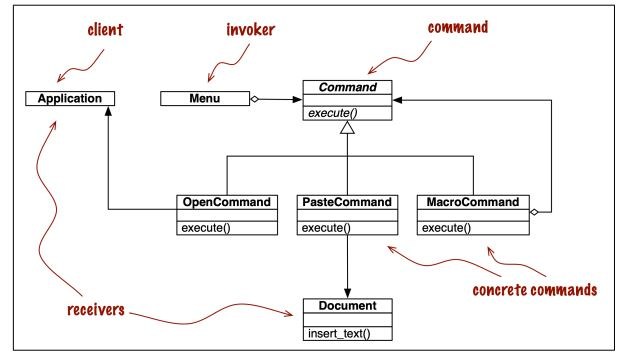


### Strategy
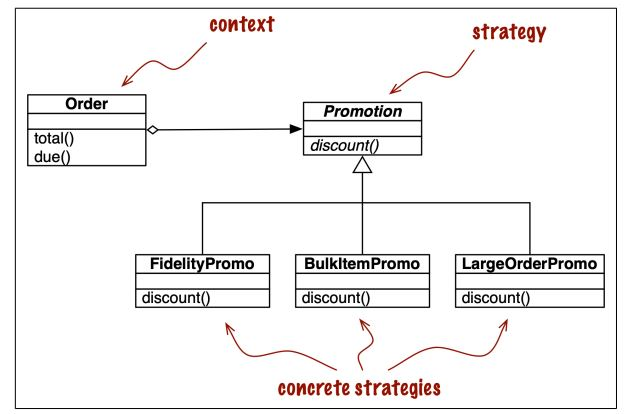

# Supplement

### Class annotations

In [23]:
class Person:
    first_name: str = "John"
    last_name: str = "Does"
    age: int = 31

### Sequence

In [24]:
from typing import Sequence

def print_sequence_elements(sequence: Sequence[str]):
    for i, s in enumerate(sequence):
        print(f"item {i}: {s}")
    
print_sequence_elements([1, 2, 3])

item 0: 1
item 1: 2
item 2: 3


### Optional

In [25]:
from typing import Optional

def foo(format_layout: Optional[bool] = True):
    ...

### Callable

In [26]:
from typing import Callable

def sum_numbers(x: int, y: int) -> int:
    return x + y

def foo(x: int, y: int, func: Callable) -> int:
    output = func(x, y)
    return output

foo(1, 2, sum_numbers)

3

### Other

In [27]:
from typing import Dict, Optional, Union

dict_of_users: Dict[int, Union[int,str]] = {
    1: "Jerome",
    2: "Lewis",
    3: 32
}

user_id: Optional[int]
user_id = None # valid
user_id = 3 # also vald
user_id = "Hello" # not valid!

print(user_id)

Hello


# Reference
- [Fluent Python Chpater 10 Design Patterns with First-Class Functions](https://bibis.ir/science-books/programming/python/2022/Fluent%20Python%20Clear,%20Concise,%20and%20Effective%20Programming,%202nd%20Edition%20by%20Luciano%20Ramalho_bibis.ir.pdf), Page (371 - 390) / 1011
- [Fluent Python second edition example code](https://github.com/fluentpython/example-code-2e/tree/master/10-dp-1class-func)
- [abc(Abstract Base Classes)](https://docs.python.org/3/library/abc.html)
- [淺談在Python中建立物件: class, namedtuple, NamedTuple and dataclass](https://medium.com/@jerrymao19/%E6%B7%BA%E8%AB%87%E5%9C%A8python%E4%B8%AD%E5%BB%BA%E7%AB%8B%E7%89%A9%E4%BB%B6-class-namedtuple-namedtuple-and-dataclass-9249fe3213)
- [12 Beginner Concepts About Type Hints To Improve Your Python Code](https://towardsdatascience.com/12-beginner-concepts-about-type-hints-to-improve-your-python-code-90f1ba0ac49)
- [Typing](https://docs.python.org/3/library/typing.html)